# TODOs:
* tutorial_5_training_config.py contains the solution for image scaling -> file has to be removed from public Git repo 

***

# Tutorial 5: Evaluate Your Model in an AWS Sagemaker Training Job

In our fourth tutorial, we used a Sagemaker training job to create a model on the full data set.
We learned that SageMaker training jobs allow us to
* monitor and log the training progress,
* keep track of the trainings we ran so far,
* decouple the actual training process from the notebook that prepares and controls our experimental setup.

Our final tutorial is about _model performance_ in terms of _prediction quality_.\
To succeed in our competition, we obviously want to obtain a model that maximizes prediction quality.
But how do we get there?

To answer this question, we will
1. sketch how to approach a data science/machine learning problem in an iterative, hypothesis-driven approach,
2. show how to obtain insights for optimizing our model and machine learning (ML) pipeline by debugging and interpreting our model's predictions, configuration, and input data.

**NOTE: We will NOT need a GPU for this tutorial notebook. Pick a non GPU instance type to save costs.**

In [3]:
import boto3           # For interacting with S3
import pandas as pd
import sys             # Python system library needed to load custom functions

# Imports to run Sagemaker training jobs
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch
from sagemaker.session import Session

In [4]:
sys.path.append('../src')  # Add the source directory to the PYTHONPATH. This allows to import local functions and modules.

In [15]:
from config import DEFAULT_BUCKET, DEFAULT_REGION  # The name of the S3 bucket that contains the training data
from detection_util import create_predictions
from gdsc_util import download_and_extract_model, set_up_logging, extract_hyperparams, PROJECT_DIR
from tutorial_4_training import load_config as load_config_4
from tutorial_5_training import load_config as load_config_5
from tutorial_5_training_8_epochs import load_config as load_config_5_with_8_epochs
from gdsc_util import load_sections_df
from PredictionEvaluator import PredictionEvaluator
from gdsc_score import get_leaderboard_score

set_up_logging()  # Sets up logging to console and .log

## Iterative, Hypothesis-driven Model Development

When we start working on a typical data science/ML problem, many aspects of the problem itself, the underlying data, and the required solution are vague.\
Repeated experimentation is key to develop an adequate solution in a systematic manner.\
Therefore, it is best practice to tackle a data science/ML problem in multiple iterations.

The [CRISP-DM process model](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) defines the relevant phases of each iteration: 

<div style="text-align: left">
    <img src="figures/crisp_dm.png" alt="CRISP-DM" style="width:33%;" />
</div>

Applying this iterative, feedback-driven process allows us to
- better understand the business problem that we want to solve,
- collect, understand, and prepare required data,
- identify and engineer relevant features from our data,
- develop/select and tune a suitable model of adequate complexity.

### The Scientific Method

A good way to plan and to carry out these iterations is to apply the [scientific method](https://en.wikipedia.org/wiki/Scientific_method).\
A key concept of this approach are _hypotheses_:
- A hypothesis is a testable statement that can either be true or false. It formulates a belief how a specific measure will influence our model's performance.
- Hypotheses are tested by conducting an experiment.

__Example:__ "Extending input data for training and inference by different stainings will increase prediction accuracy."

Before the first iteration, we create a list of initial hypotheses and sort it by priority. Priorities can be assigned by expected information gain or risk, for instance.\
Having created such an initial list, each iteration looks as follows:
1. Select the hypothesis of highest priority.
2. Conduct an experiment to test the influence of the measure on the model's performance.
3. Investigate the outcome and use the gained insights to derive further hypotheses. Adjust priorities if required. 

Note that this approach not only helps us in prioritizing our investigations, but also forces us to justify our design decisions.\
As a consequence, different aspects of the problem are better understood and complexity is only added if needed.\
The latter characteristic is especially important when having to adapt to changes in the future.

### A First List of Hypotheses

With regard to our detection problem, we start testing the following hypotheses in the given order:
1. Tuning the MMDetection configuration with respect to the input data will increase prediction quality.
2. Ignoring the model's detection score deteriorates prediction quality.
3. Overfitting impairs our model's generalizability.

In the following sections, we will test these hypotheses to improve our model and guide further investigations.

## Analyzing Model Performance and Tuning the Configuration

Hypothesis:
> Tuning the MMDetection configuration with respect to the input data will increase prediction quality.

To test this hypothesis, let's first take a look at the logs of a training job of Tutorial 4.\
To this end, we navigate to a corresponding SageMaker traning job in the AWS management console and open its log output in CloudWatch (see Tutorial 4).

The log shows that, after 4 epochs, we get a recall of about 0.7. This means that our model does not detect quite many sections. The score we got assigned on the [GDSC website](https://gdsc.ce.capgemini.com/) was around 75.\
We should be able to do much better than this!
It seems that our model is currently not able to extract as much information from the data as needed to provide adequate predictions.

Let's check again the configuration we used in Tutorial 4:

In [7]:
entry_point = 'tutorial_4_training.py'
exp_name = entry_point.split('.')[0].replace('_', '-')  # AWS does not allow . and _ as experiment names

account_id = boto3.client('sts').get_caller_identity().get('Account')
role = get_execution_role() # or locally: role = "arn:aws:iam::{account_id}:role/service-role/{studio_role_name}"  

sm_client = boto3.client("sagemaker", region_name=DEFAULT_REGION)
sess = Session(sagemaker_client=sm_client)
s3_output_location = f"s3://{sess.default_bucket()}/{exp_name}"
input_channels = {"train": f"s3://{DEFAULT_BUCKET}"}

data_folder = str(PROJECT_DIR / 'data')
cfg, base_file = load_config_4(data_folder)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

A very careful look at the configuration (or the MMdetection [tutorial](https://mmdetection.readthedocs.io/en/latest/tutorials/config.html)) reveals the interesting parameter ```cfg.model.test_cfg.rcnn.max_per_img```. It limits the maximal number of sections that can be predicted per image.

Currently, this value is set to 100:

In [34]:
cfg.model.test_cfg.rcnn.max_per_img

100

Intuitively, we should ensure that the parameter value is not smaller than the maximum of the number of bounding boxes per image.\
So how many bounding boxes do we have per image?

<AxesSubplot:>

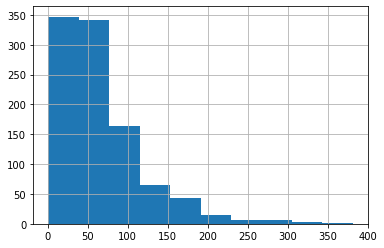

In [35]:
section_df = load_sections_df(f'{PROJECT_DIR}/data/gdsc_train.csv')
nodules = section_df.groupby(['file_name','staining','study']).size().sort_values(ascending=False).reset_index()  # Group the data by nodule image
nodules[0].hist()

In [36]:
display(nodules.head(5))
fraction = len(nodules[nodules[0] > 100])/float(len(nodules))
print('Fraction >100: {:.1%}'.format(fraction))

,file_name,staining,study,0
0,253_A.jpg,A,Study_2,381
1,294_DD.jpg,DD,Study_3,336
2,294_B.jpg,B,Study_3,332
3,294_A.jpg,A,Study_3,331
4,251_A.jpg,A,Study_2,291


Fraction >100: 19.0%


According to the histogram, there are quite many nodules with 100-200 sections.
The table above shows that we even have 4 nodules with more than 300 sections. So way more than our current limit of 100.
In fact, almost 20% of all nodules in our training set feature more than 100 sections.

So it is valid to assume that the current value of ```cfg.model.test_cfg.rcnn.max_per_img``` is too low.
To have some buffer for the test data, we will set it to 400.

We have prepared this adjusted configuration in the training code for Tutorial 5.
So we just load it in the following step.

In [37]:
entry_point = 'tutorial_5_training.py'
exp_name = entry_point.split('.')[0].replace('_', '-')  # AWS does not allow . and _ as experiment names

account_id = boto3.client('sts').get_caller_identity().get('Account')
role = get_execution_role() # or locally: role = "arn:aws:iam::{account_id}:role/service-role/{studio_role_name}"  

sm_client = boto3.client("sagemaker", region_name=DEFAULT_REGION)
sess = Session(sagemaker_client=sm_client)
s3_output_location = f"s3://{sess.default_bucket()}/{exp_name}"
input_channels = {"train": f"s3://{DEFAULT_BUCKET}"}

data_folder = str(PROJECT_DIR / 'data')
cfg, base_file = load_config_5(data_folder)

hyperparameters = extract_hyperparams(entry_point) # custom function to parse the training script and extract config
hyperparameters['base_file'] = base_file

metrics = [
    {"Name": "train:loss_rpn_cls", "Regex": "loss_rpn_cls: ([0-9\.]+)"},
    {"Name": "train:loss_rpn_bbox", "Regex": "loss_rpn_bbox: ([0-9\.]+)"},
    {"Name": "train:loss_cls", "Regex": "loss_cls: ([0-9\.]+)"},
    {"Name": "train:loss_bbox", "Regex": "loss_bbox: ([0-9\.]+)"},
    {"Name": "train:loss", "Regex": "loss: ([0-9\.]+)"},
    {"Name": "train:accuracy", "Regex": "acc: ([0-9\.]+)"},
    {"Name": "train:epoch", "Regex": "Epoch (\[[0-9\.]+\])"},
    {"Name": "val:epoch", "Regex": "Epoch\(val\) (\[[0-9]+\])"},
    {"Name": "val:mAP", "Regex": "mAP: ([0-9\.]+)"},
]

cfg.model.test_cfg.rcnn.max_per_img

400

We re-train our model to test if the prediction quality of our model increases.

Note that we also extended our training script by two prediction steps on train and test data.
These predictions are created automatically after the training is completed. They are stored in two CSV files &mdash; one for "train" and another one for "test". After downloading and extracting the generated model, both files are located in your project's data folder. This is the same location where you found the generated predictions of Tutorial 4.

This functionality will become handy in the course of this tutorial.

In [38]:
estimator = PyTorch(
    entry_point=entry_point,             # This function will be called by the training job
    source_dir="../src",                 # All code in this folder will be copied over
    image_uri=f"954362353459.dkr.ecr.{DEFAULT_REGION}.amazonaws.com/sm-training-custom:torch-1.8.1-cu111-noGPL",
    role=role,
    output_path=s3_output_location,
    container_log_level=20,             # 10=debug, 20=info
    base_job_name=exp_name,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",     # a GPU instance
    volume_size=45,
    metric_definitions=metrics,
    hyperparameters=hyperparameters,
)

In [ ]:
estimator.fit(
    input_channels,
    wait=False,           # Whether or not the notebook should wait for the job to finish. By setting it to False we can continue working while the job runs on another machine.
)

In [23]:
model_location = f'{s3_output_location}/{estimator._hyperparameters["sagemaker_job_name"]}/output/model.tar.gz'
local_model_dir = download_and_extract_model(model_uri=model_location, local_dir='data')

2022-06-03 22:15:00,649 - gdsc_util - INFO - File tutorial-5-training/tutorial-5-training-2022-05-29-10-30-56-102/output/model.tar.gz already exists. Skipping download


With the parameter adjustment, you should now get a recall of about 0.8 (recall that the previous recall was ~0.7).\
Submitting the results on the [GDSC website](https://gdsc.ce.capgemini.com/) reveals a more disappointing result:
_Our score decreased from 75 to 66!_

To understand this behavior, recap that the assigned score is the sum of multiple accuracy values our model obtains for different IoU thresholds (see Tutorial 3, for instance).
Interestingly, a major difference between the accuracy and the recall metrics is that recall does not take account of _false positives_. 

So it is valid to assume that the drop in overall performance is due to an increased number of false positives.
The following observations supprt this assumption:
1. The statistics of the section counts shows that 75% of our nodules do not have more than 86 sections. This is far less than the 400 regions the model can detect. 
2. Checking the training logs reveals that the model detects ~105k regions with the new configuration, compared to ~95k with the old configuration. Many of these additional regions could be false positives given that most nodules exhibit relatively few sections.

In [40]:
nodules.describe()

,0
count,994.000000
mean,66.083501
std,54.383185
min,1.000000
25%,28.250000
50%,53.000000
75%,86.000000
max,381.000000


So far, our hypothesis did not turn out to be _true_.
We still keep the updated configuration since the experiment's outcome supports our idea of investigating the model's detection score in the next section.

## Avoiding False Detections/Positives

Refined hypothesis:
> Ignoring the model's detection score deteriorates prediction quality due to false positives.

Currently, every bounding box that our model draws is considered a detected section.\
In the following experiment, we will test if ignoring our model's confidence (i.e., detection score) in predicted bounding boxes deteriorates its prediction quality. 

To recap how the predictions look like, we load the predictions on training data created by the model trained using the updated configuration in the previous section:

In [8]:
prediction_df = pd.read_csv(f'{data_folder}/tutorial-5-training-2022-05-29-10-30-56-102/results_tutorial5_train_epoch_4.csv', sep=';')
prediction_df

,section_id,file_name,xmin,ymin,xmax,ymax,detection_score
0,102_A.jpg@3297-4216-2777-3165,102_A.jpg,3297,2777,4216,3165,0.978597
1,102_A.jpg@3221-3544-5465-6349,102_A.jpg,3221,5465,3544,6349,0.967986
2,102_A.jpg@2719-3498-4852-5194,102_A.jpg,2719,4852,3498,5194,0.961160
3,102_A.jpg@3528-3867-4057-5085,102_A.jpg,3528,4057,3867,5085,0.954487
4,102_A.jpg@2171-2839-1868-2386,102_A.jpg,2171,1868,2839,2386,0.941419
...,...,...,...,...,...,...,...
107831,9_D.jpg@3111-3692-2444-3082,9_D.jpg,3111,2444,3692,3082,0.051561
107832,9_D.jpg@2825-3153-1301-1698,9_D.jpg,2825,1301,3153,1698,0.051457
107833,9_D.jpg@2110-2584-1101-1989,9_D.jpg,2110,1101,2584,1989,0.051006
107834,9_D.jpg@903-1636-3752-4494,9_D.jpg,903,3752,1636,4494,0.050689


The statistics show us that, in fact, the model has quite low confidence values (<= 0.35) for 50% of the detections:

In [10]:
prediction_df.describe()

,xmin,ymin,xmax,ymax,detection_score
count,107836.000000,107836.000000,107836.000000,107836.000000,107836.000000
mean,3007.071822,3575.800271,3449.560601,4103.073899,0.426875
std,1443.705168,1609.879749,1475.469295,1637.756149,0.327494
min,0.000000,0.000000,243.000000,248.000000,0.050003
25%,1888.000000,2285.000000,2310.000000,2801.000000,0.100776
50%,2837.500000,3474.000000,3295.000000,4042.000000,0.344173
75%,3953.000000,4792.000000,4420.000000,5373.000000,0.765656
max,7862.000000,7965.000000,8141.000000,8191.000000,0.993109


To investigate how this impacts prediction quality, we first run the evaluation function we use to calculate leaderboard scores against these predictions for different IoU thresholds.\
The reported score is the sum of the _detection_acc@X_ values.

In [11]:
ground_truth = load_sections_df(f'{data_folder}/gdsc_train.csv')

evaluator = PredictionEvaluator(ground_truth)
thresholds = [0.5, 0.6, 0.7]
get_leaderboard_score(prediction_df, thresholds, evaluator)

2022-06-03 17:33:21,007 - gdsc_score - INFO - Computing results for threshold: 0.5
2022-06-03 17:33:21,008 - PredictionEvaluator - INFO - Matching sections


100%|██████████| 994/994 [01:21<00:00, 12.18it/s]

2022-06-03 17:34:42,665 - PredictionEvaluator - INFO - Merging matched sections


2022-06-03 17:34:42,813 - PredictionEvaluator - INFO - Done matching sections
2022-06-03 17:34:42,817 - PredictionEvaluator - INFO - Evaluating predictions
2022-06-03 17:34:42,818 - PredictionEvaluator - INFO - Computing overall scores
2022-06-03 17:34:42,836 - gdsc_score - INFO - Computing results for threshold: 0.6
2022-06-03 17:34:42,836 - PredictionEvaluator - INFO - Matching sections


 28%|██▊       | 280/994 [00:23<00:59, 12.08it/s]


KeyboardInterrupt: 

Now we run the function again &mdash; but this time only on detected regions with a confidence score greater than 0.5:

In [ ]:
get_leaderboard_score(prediction_df[prediction_df.detection_score>0.5], thresholds, evaluator)

We can see that, when relying on a minimal detection score, the number of false positives decreases by about an order of magnitude for all IoU thresholds.\
Consequently, we achieve a significantly higher accuracy.
Also, precision improves since the ratio of true positives to false positives increased.

On the other hand, the number of false negatives also grows a lot. It doubles for IoU thresholds 0.5 and 0.6. This indicates that the model is oftentimes uncertain about true sections.

Next, we test the influence on the test score by exporting and submitting filtered test predictions.

In [12]:
prediction_df = pd.read_csv(f'{data_folder}/tutorial-5-training-2022-05-29-10-30-56-102/results_tutorial5_test_epoch_4.csv', sep=';')
restricted_prediction_df = prediction_df[prediction_df.detection_score>0.5]
restricted_prediction_df.to_csv(f'{data_folder}/results_tutorial5_epoch_4_min_detection_score.csv', sep=';')

2022-06-03 17:35:10,091 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


Great news, our assumption was correct! With this measure, we can boost our model's score to 90.

**Exercises:**
- Pick some nodules from the training data and check which detected sections are below the detection score threshold. Do you agree to sort out these detections?
- Use the model of Tutorial 4 together with a detection score threshold of 0.5 to generate predictions on training data. How does the calculatd leaderboard score compare to the results we obtained here with ```cfg.model.test_cfg.rcnn.max_per_img = 400```?
- Find a threshold that further improves your model's performance. How can you find an adequate threshold with a low number of training runs? A good method saves time, energy, and money. Do not use a brute-force search!

## Do we Overfit?

Having conducted some experiments with the setup of Tutorial 4, we see that the mAP metric stagnates and sometimes starts fluctuating around ~0.65 after 2-3 epochs:
<br>
<br>
<img src="figures/overfitting_logs.png" alt="Do we overfit?" style="width:40%;" />
    
In addition, we observe that we obtain much higher leaderboard scores on training than on test data. For instance, 165 vs. 90 for the experiment in the previous section.  

Hypothesis:
> Overfitting impairs our model's generalizability.

To test this hypothesis, it is important to understand what _overfitting_ is and how it relates to _underfitting_.

### Overfitting

_Overfitting_ describes a situation in which a model is able to remember too many little details of the training data.
In the worst case, the model simply memorizes the input-output relation for every training example.\
While an overfitting model performs very well on training data, it underperforms on validation/test data.
In other words, it lacks ability to _generalize_.

Overfitting can be identified by comparing training to validation/test losses:
- Overfitting is indicated if the validation/test loss stagnates while the training loss continuous to improve.
- If, in further epochs, the validation/test loss starts getting worse again, the model clearly overfits.

<div style="text-align: left">
    <img src="figures/overfitting_loss.png" alt="Overfitting - Loss" style="width:550px;" />
</div>

(Figure taken from [IBM Cloud Learn Hub: Overfitting](https://www.ibm.com/cloud/learn/overfitting))

### Underfitting

_Underfitting_ occurs if the model is not able to capture relevant patterns from the training data.
As a result, the model makes a lot of wrong predictions so that its training and validation/test losses remain at a high level.\
There are several reasons for underfitting. For example:
- Lack of model complexity
- Use of unsuitable or insufficient features
- Insufficient number of training iterations

### Overfitting vs. Underfitting

The following figure compares an underfitting (left), a well generalizing (middle), and an overfitting model (right):

<div style="text-align: left">
    <img src="figures/underfitting_overfitting.png" alt="Overfitting" style="width:75%" />
</div>

(Figure taken from [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html))


**Further reading:**
- [This article](https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765) outlines over-/underfitting in more detail.
- [This article](https://towardsdatascience.com/8-simple-techniques-to-prevent-overfitting-4d443da2ef7d) presents different techniques you can apply to deal with overfitting. 
- [This article](http://scott.fortmann-roe.com/docs/BiasVariance.html) provides a detailed discussion on the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) and its relation to over- and underfitting.


### Do we Really Overfit?

Based on the definitions above, we cannot come to the conclusion that our model overfits.\
The main reason for this is that our training logs do not contain information on how the validation/test loss develops in comparison to the training loss. 

To check if we overfit, we train a new model with our most recent configuration for 8 epochs. Afterwards, we compute the leaderboard score and compare it with the one we obtained for 4 epochs.

In [16]:
entry_point = 'tutorial_5_training_8_epochs.py'
exp_name = entry_point.split('.')[0].replace('_', '-')  # AWS does not allow . and _ as experiment names

account_id = boto3.client('sts').get_caller_identity().get('Account')
role = get_execution_role() # or locally: role = "arn:aws:iam::{account_id}:role/service-role/{studio_role_name}"  

sm_client = boto3.client("sagemaker", region_name=DEFAULT_REGION)
sess = Session(sagemaker_client=sm_client)
s3_output_location = f"s3://{sess.default_bucket()}/{exp_name}"
input_channels = {"train": f"s3://{DEFAULT_BUCKET}"}

data_folder = str(PROJECT_DIR / 'data')
cfg, base_file = load_config_5_with_8_epochs(data_folder)

hyperparameters = extract_hyperparams(entry_point) # custom function to parse the training script and extract config
hyperparameters['base_file'] = base_file

metrics = [
    {"Name": "train:loss_rpn_cls", "Regex": "loss_rpn_cls: ([0-9\.]+)"},
    {"Name": "train:loss_rpn_bbox", "Regex": "loss_rpn_bbox: ([0-9\.]+)"},
    {"Name": "train:loss_cls", "Regex": "loss_cls: ([0-9\.]+)"},
    {"Name": "train:loss_bbox", "Regex": "loss_bbox: ([0-9\.]+)"},
    {"Name": "train:loss", "Regex": "loss: ([0-9\.]+)"},
    {"Name": "train:accuracy", "Regex": "acc: ([0-9\.]+)"},
    {"Name": "train:epoch", "Regex": "Epoch (\[[0-9\.]+\])"},
    {"Name": "val:epoch", "Regex": "Epoch\(val\) (\[[0-9]+\])"},
    {"Name": "val:mAP", "Regex": "mAP: ([0-9\.]+)"},
]

estimator = PyTorch(
    entry_point=entry_point,             # This function will be called by the training job
    source_dir="../src",                 # All code in this folder will be copied over
    image_uri=f"954362353459.dkr.ecr.{DEFAULT_REGION}.amazonaws.com/sm-training-custom:torch-1.8.1-cu111-noGPL",
    role=role,
    output_path=s3_output_location,
    container_log_level=20,             # 10=debug, 20=info
    base_job_name=exp_name,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",     # a GPU instance
    volume_size=45,
    metric_definitions=metrics,
    hyperparameters=hyperparameters,
)

estimator.fit(
    input_channels,
    wait=False,           # Whether or not the notebook should wait for the job to finish. By setting it to False we can continue working while the job runs on another machine.
)

# save the model location to the filesystem so that we can use it later
model_location = f'{s3_output_location}/{estimator._hyperparameters["sagemaker_job_name"]}/output/model.tar.gz'

with open(f'{PROJECT_DIR}/model_location_tut5.txt', 'w+') as f:
    f.write(model_location)

2022-06-03 18:23:16,822 - sagemaker.image_uris - INFO - Defaulting to the only supported framework/algorithm version: latest.
2022-06-03 18:23:16,839 - sagemaker.image_uris - INFO - Ignoring unnecessary instance type: None.
2022-06-03 18:23:17,056 - sagemaker - INFO - Creating training-job with name: tutorial-5-training-8-epochs-2022-06-03-18-23-16-821


In [21]:
# read the model location from the filesystem
with open(f'{PROJECT_DIR}/model_location_tut5.txt', 'r') as f:
    model_location = f.read()

local_model_dir = download_and_extract_model(model_uri=model_location, local_dir='data')

In [22]:
prediction_df = pd.read_csv(f'{data_folder}/tutorial-5-training-8-epochs-2022-06-03-18-23-16-821/results_tutorial5_test_epoch_8.csv', sep=';')
restricted_prediction_df = prediction_df[prediction_df.detection_score>0.5]
restricted_prediction_df.to_csv(f'{data_folder}/results_tutorial5_epoch_8_min_detection_score.csv', sep=';')

Training the model for 8 epochs leads to a significantly higher leaderbord score of 110, instead of 90 for 4 epochs. So the model is clearly not overfitting!\
However, increasing model performance by training for more and more epochs is not an option. This is simply too time-consuming and too costly.

Maybe our model just shows a low _convergence rate_ because it is not able to extract all relevant features from the input data?\
We will cover this in the following exercises.

**Exercises:**
- Think about possibilities to support our model in extracting features from input data. Hint: Check the size of the images we loaded in Tutorial 2, and compare them to the scale of the images in the model's configuration (look out for the parameter "img_scale").
- Evaluate how the model performs on different stainings or studies. Should we train individual models for them?

## Summary

This tutorial showed how we can systematically improve our model in an interative manner:
- We learned how to apply CRISP-DM and the scientific method to plan, prioritize, and carry out iterations.
- We formulated an initial list of hypotheses and adapted them on the basis of gained insights.
- We made our model more powerful by increasing the maximal number of detectable sections.
- We improved the model's predictions by making use of the provided detection scores as a measure of confidence.
- We discussed properties of over- and underfitting and derived further hypotheses.

Now you should be well-equipped to tackle the Global Data Science Challenge 2022.\
We wish you and your team good luck and a lot of fun!